In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import scipy.misc as spm
import scipy.ndimage as spn

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
pickle_file = 'notMNIST_clean.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory

In [4]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size)).astype(np.float32) # Conv net
    #(-1, image_size, image_size)).astype(np.float32)  # Deep net
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print(train_dataset.shape)

empty_label = np.zeros(num_labels)

(200000, 28, 28)


0.5 -0.5


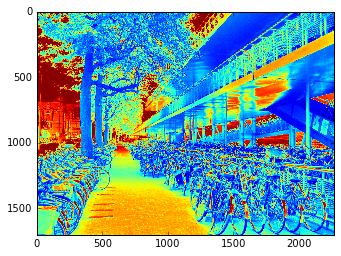

(1704, 2272)
0.5 -0.5


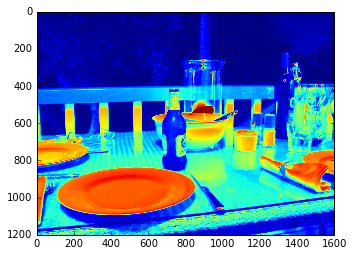

(1200, 1600)
0.5 -0.5


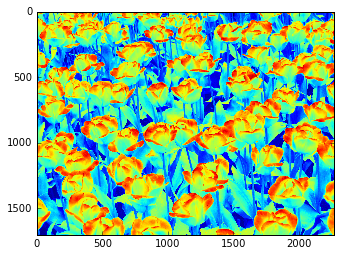

(1704, 2272)


In [5]:
# Load some backgrounds so we can get intersting pictures
def load_backgrounds(files):
    import matplotlib.image as mpimg
    def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    
    results = []
    for filename in files:
        img=rgb2gray(mpimg.imread(filename)).astype(np.uint8).astype(float)
        img = img / np.max(img) - 0.5
        results.append(img)
        
        print(np.max(img), np.min(img))
        plt.imshow(img)
        plt.show()
        print(img.shape)
    return results

backgrounds = load_backgrounds([
    'backgrounds/IMG_4831.jpg',
    'backgrounds/100-0048_IMG.JPG',
    #'backgrounds/117-1710_IMG.JPG',
    #'backgrounds/116-1607_IMG.JPG',
    #'backgrounds/BRAD 3_001_P_025A.jpg',
    'backgrounds/IMG_4848.jpg'
])

With training data
Image shape: (28, 28, 1)
float32


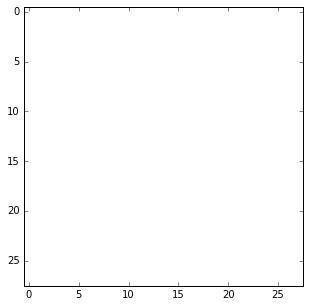

Label shape: (1, 10)
I
With testing data
Image shape: (28, 28, 1)
float32


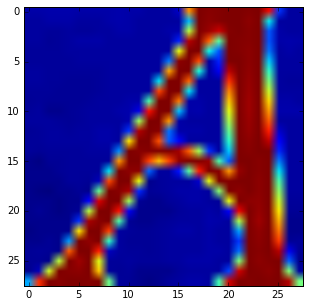

Label shape: (1, 10)
A


In [51]:
def create_image_random(train, labels, length=5, backgrounds=None):
    new_length = np.random.randint(length) + 1
    
    im_height = 40
    im_width = 40
    
    #invert = np.random.uniform() > 0.7
        
    result_img = np.ones([im_height, im_width]) * -0.5
    result_labels = []
        
    
    digit_height = train[0].shape[0]
    digit_width = train[0].shape[1]
    
    x_shrink = .8 * (np.random.normal(scale=0.1) + 1)
    y_shrink = np.random.normal(scale=0.2) + 1.3
           
    # standard letter spacing is the width + 10%
    x_spacing = (digit_width * 1.1) * (np.random.normal(scale=0.1) + 1) * x_shrink
            
    # y spacing randomly go up and down a little
    y_spacing = np.random.normal(scale=0.2) * 10
        
    rotate = np.random.normal() * 5
        
    y = (result_img.shape[0] / 2.) # Middle of picture
    y = y - (y_shrink * digit_height / 2.)  # Average height
    y = y - ((length-1) * y_spacing / 2.) # y_spacing
    
    x = result_img.shape[1] / 2. - (new_length * x_spacing) / 2.
    
    for a in range(new_length):
        # Choose random indexes for the digits
        index = np.random.randint(0, labels.shape[0])
                
        result_img = train[index]
#         img = train[index]        
#         img = spm.imrotate(img, rotate)
#         img = spn.interpolation.zoom(img, [y_shrink, x_shrink])
        
#         # normalise the picture again
#         img = img.astype(float)
#         img = (img / np.max(img)) - 0.5
                
#         rows, cols = img.shape
#         cx = int(x)
#         cy = int(y)
#         print(x,y,rows,cols)
#         result_img[cy:cy+rows, cx:cx+cols] = img
        
#         del img # memory?
        
#         x += x_spacing
#         y += y_spacing
        
        result_labels.append(labels[index])
        

    if backgrounds is not None:
        pic = backgrounds[np.random.randint(len(backgrounds))]
        xs = np.random.randint(pic.shape[0] - result_img.shape[0])
        ys = np.random.randint(pic.shape[1] - result_img.shape[1])
        
        background_pic = pic[xs:xs+result_img.shape[0], ys:ys+result_img.shape[1]]
        
        rep = result_img <= -0.45
        
        output = (result_img *  np.invert(rep)) + rep * background_pic
        result_img = output
        
    result_img = result_img.astype(np.float32) - np.min(result_img)
    result_img = result_img / np.max(result_img) - 0.5
        
    while len(result_labels) < length:
        result_labels.append(np.zeros(labels[0].shape))
        
    final_img = np.reshape(result_img.astype(np.float32), list(result_img.shape) + [1])
    return final_img, np.array(result_labels)

def show_image(data):
    print("Image shape:", data.shape)
    plt.figure(figsize=(20, 5))
    plt.imshow(np.reshape(data, data.shape[:-1]))
    print(data.dtype)
    plt.show()
    
def show_label(label):
    print("Label shape:", label.shape)
    result = ''
    for a in label:
        index = np.argmax(a)
        result += chr(ord('A') + index)
    print(result)
    
print("With training data")
image, label = create_image_random(train_dataset, train_labels, length=1, backgrounds=backgrounds)
show_image(image)
show_label(label)

print("With testing data")
image, label = create_image_random(test_dataset, test_labels, length=1, backgrounds=backgrounds)
show_image(image)
show_label(label)

Label shape: (1, 10)
J
Image shape: (28, 28, 1)
float32


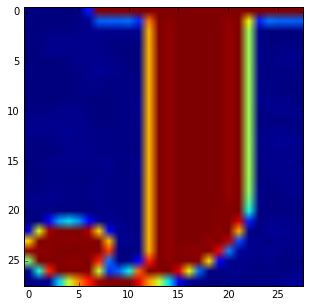

Label shape: (1, 10)
D
Image shape: (28, 28, 1)
float32


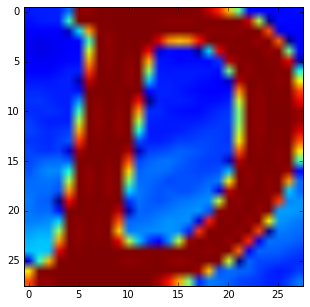

Label shape: (1, 10)
C
Image shape: (28, 28, 1)
float32


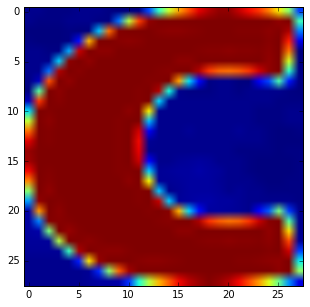

In [52]:
# Create a batch of images and labels
def generate_batch(data, labels, size, length, **kwargs):    
    images, labels = zip(*[create_image_random(data, labels, length, **kwargs) for i in range(size)])
        
    result_images = np.array(images)
    result_labels = np.array(labels)
    
    return result_images, result_labels

imgs, labels = generate_batch(train_dataset, train_labels, 3, 1, backgrounds=backgrounds)
for i in range(len(imgs)):
    show_label(labels[i])
    show_image(imgs[i])

In [53]:
# Lets create our training, validation and testing datasets
num_digits = 1

train_dataset_imgs, train_dataset_labels = generate_batch(train_dataset, train_labels, 10000, num_digits)
valid_dataset_imgs, valid_dataset_labels = generate_batch(valid_dataset, valid_labels, 1000, num_digits)
test_dataset_imgs, test_dataset_labels = generate_batch(test_dataset, test_labels, 1000, num_digits)

In [54]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

img_height, img_width = test_dataset_imgs[0].shape[:2]

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                       img_height,
                                                       img_width,
                                                       num_channels), name="tf_train_dataset")
    
  tf_train_labels = [tf.placeholder(tf.float32, shape=(batch_size,
                                                      num_labels), name="tf_train_labels_%d" % i)
                     for i in range(num_digits)]
  tf_valid_dataset = tf.constant(valid_dataset_imgs, name="tf_valid_dataset")
  tf_test_dataset = tf.constant(test_dataset_imgs, name="tf_test_dataset")
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    num_channels,
                                                    depth], stddev=0.1), name="layer1_weights")
  layer1_biases = tf.Variable(tf.zeros([depth]), name="layer1_biases")

  layer2_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    depth,
                                                    depth], stddev=0.1), name="layer2_weights")
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]), name="layer2_biases")

  layer3_weights = tf.Variable(tf.truncated_normal([int(round(img_height / 4.)) * int(round(img_width / 4.)) * depth,
                                                    num_hidden], stddev=0.1), name="layer3_weights")
    
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]), name="layer3_biases")

  layer4_weights = [tf.Variable(tf.truncated_normal([num_hidden,
                                                    num_labels], stddev=0.1), name="layer4_weights")
                    for i in range(num_digits)]
  layer4_biases = [tf.Variable(tf.constant(1.0, shape=[num_labels]), name="layer4_biases")
                   for i in range(num_digits)]

   
    
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    output = [tf.matmul(hidden, layer4_weights[i]) + layer4_biases[i]
              for i in range(num_digits)]
    return output
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean([
    tf.nn.softmax_cross_entropy_with_logits(logits[i], tf_train_labels[i])
        for i in range(num_digits)])
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = [tf.nn.softmax(a) for a in logits]
  valid_prediction = [tf.nn.softmax(a) for a in model(tf_valid_dataset)]
  test_prediction = [tf.nn.softmax(a) for a in model(tf_test_dataset)]

In [62]:
num_steps = 1001

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])


with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    
    offset = (step * batch_size) % (train_dataset_imgs.shape[0] - batch_size)
    batch_data = train_dataset_imgs[offset:(offset + batch_size), :, :, :]
    batch_labels = train_dataset_labels[offset:(offset + batch_size), :]

    
    feed_dict = {tf_train_dataset : batch_data}
    for i in range(num_digits):
        labels = batch_labels[:, i, :]
        feed_dict[tf_train_labels[i]] = labels

    fetches = [optimizer, loss] + train_prediction
    
    results = session.run(fetches, feed_dict=feed_dict)
    
    
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, results[1]))       
        
      print('Minibatch accuracy: %.1f%%' % np.mean([accuracy(results[2+i], batch_labels[:, i, :])
                                                    for i in range(num_digits)]))
      print('Validation accuracy: %.1f%%' % np.mean([accuracy(valid_prediction[i].eval(),
                                                              valid_dataset_labels[:, i, :])
                                                     for i in range(num_digits)]))
  print('Test accuracy: %.1f%%' % np.mean([accuracy(test_prediction[i].eval(),
                                                    test_dataset_labels[:, i, :])
                                           for i in range(num_digits)]))

Initialized
Minibatch loss at step 0: 2.737440
Minibatch accuracy: 6.2%
Validation accuracy: 10.7%
Minibatch loss at step 50: 2.296543
Minibatch accuracy: 12.5%
Validation accuracy: 9.8%
Minibatch loss at step 100: 2.308664
Minibatch accuracy: 6.2%
Validation accuracy: 11.4%
Minibatch loss at step 150: 2.291054
Minibatch accuracy: 12.5%
Validation accuracy: 9.8%
Minibatch loss at step 200: 2.309761
Minibatch accuracy: 6.2%
Validation accuracy: 11.6%
Minibatch loss at step 250: 2.301853
Minibatch accuracy: 6.2%
Validation accuracy: 11.6%
Minibatch loss at step 300: 2.297208
Minibatch accuracy: 12.5%
Validation accuracy: 11.6%
Minibatch loss at step 350: 2.304463
Minibatch accuracy: 12.5%
Validation accuracy: 10.2%
Minibatch loss at step 400: 2.303206
Minibatch accuracy: 12.5%
Validation accuracy: 8.9%
Minibatch loss at step 450: 2.300079
Minibatch accuracy: 6.2%
Validation accuracy: 8.9%
Minibatch loss at step 500: 2.293613
Minibatch accuracy: 25.0%
Validation accuracy: 8.9%
Minibatch l

In [60]:
625*16

10000

Label shape: (1, 10)
D
Image shape: (28, 28, 1)


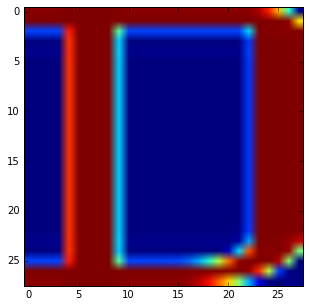

In [11]:
show_label(valid_dataset_labels[0])
show_image(valid_dataset_imgs[0])